In [63]:
# Importing the libraries
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt


In [64]:
data = pd.read_csv('bank_data.csv')

# Display basic information and the first few rows of the dataset to understand its structure and determine preprocessing steps
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4268 entries, 0 to 4267
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                4268 non-null   int64  
 1   id                        4268 non-null   int64  
 2   dependents                4268 non-null   int64  
 3   education                 4268 non-null   object 
 4   self_employed             4268 non-null   object 
 5   income_annual             4055 non-null   float64
 6   loan_amount               4268 non-null   int64  
 7   loan_term                 4268 non-null   int64  
 8   cibil_score               4268 non-null   int64  
 9   residential_assets_value  4268 non-null   int64  
 10  commercial_assets_value   4268 non-null   int64  
 11  luxury_assets_value       4268 non-null   int64  
 12  bank_asset_value          3927 non-null   float64
 13  loan_status               4268 non-null   object 
dtypes: float

,Unnamed: 0,id,dependents,education,self_employed,income_annual,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,0,1,2,Graduate,No,9600000.0,29900000,12,778,2400000,17600000,22700000,NaN,Approved
1,1,2,0,Not Graduate,Yes,4100000.0,12200000,8,417,2700000,2200000,8800000,3300000.0,Rejected
2,2,3,3,Graduate,No,9100000.0,29700000,20,506,7100000,4500000,33300000,12800000.0,Rejected
3,3,4,3,Graduate,No,8200000.0,30700000,8,467,18200000,3300000,23300000,7900000.0,Rejected
4,4,5,5,Not Graduate,Yes,9800000.0,24200000,20,382,12400000,8200000,29400000,5000000.0,Rejected


In [65]:
# Dropping unnecessary columns
data = data.drop(columns=['Unnamed: 0', 'id'])

# Handling missing values
imputer = SimpleImputer(strategy='median')
data[['income_annual', 'bank_asset_value']] = imputer.fit_transform(data[['income_annual', 'bank_asset_value']])

# Encoding categorical variables
data['education'] = LabelEncoder().fit_transform(data['education'])
data['self_employed'] = LabelEncoder().fit_transform(data['self_employed'])
data['loan_status'] = LabelEncoder().fit_transform(data['loan_status'])

# Splitting the dataset into features and target variable
X = data.drop('loan_status', axis=1)
y = data['loan_status']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((3414, 11), (854, 11), (3414,), (854,))

In [97]:
data.to_csv("finalfile.csv", index = False)

In [66]:
# Converting the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float).view(-1, 1)

In [96]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
            in_features = hidden_size
        layers.append(nn.Linear(in_features, output_size))
        layers.append(nn.Sigmoid())
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

def train_and_evaluate_model(learning_rate, hidden_sizes):
    model = MLP(input_size=11, hidden_sizes=hidden_sizes, output_size=1)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    epochs = 100
    start_time = time.time()
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    
    training_time = time.time() - start_time
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        predicted_classes = predictions.round()
        accuracy = (predicted_classes == y_test_tensor).float().mean().item()
    
    return training_time, accuracy

# Parameters to test
hidden_size_options = [[64], [64, 32], [64, 32, 16]]
learning_rate_options = [0.1, 0.01, 0.001]

# Results storage
results = []

for hidden_sizes in hidden_size_options:
    for learning_rate in learning_rate_options:
        training_time, accuracy = train_and_evaluate_model(learning_rate, hidden_sizes)
        results.append({
            'hidden_sizes': hidden_sizes,
            'learning_rate': learning_rate,
            'training_time': training_time,
            'accuracy': accuracy
        })

# Display results
for result in results:
    print(f"Hidden Sizes: {result['hidden_sizes']}, Learning Rate: {result['learning_rate']}, "
          f"Training Time: {result['training_time']:.2f}s, Accuracy: {result['accuracy']:.4f}"


Hidden Sizes: [64], Learning Rate: 0.1, Training Time: 0.07s, Accuracy: 0.9696
Hidden Sizes: [64], Learning Rate: 0.01, Training Time: 0.04s, Accuracy: 0.9438
Hidden Sizes: [64], Learning Rate: 0.001, Training Time: 0.04s, Accuracy: 0.8724
Hidden Sizes: [64, 32], Learning Rate: 0.1, Training Time: 0.07s, Accuracy: 0.9532
Hidden Sizes: [64, 32], Learning Rate: 0.01, Training Time: 0.07s, Accuracy: 0.9473
Hidden Sizes: [64, 32], Learning Rate: 0.001, Training Time: 0.07s, Accuracy: 0.9204
Hidden Sizes: [64, 32, 16], Learning Rate: 0.1, Training Time: 0.08s, Accuracy: 0.9637
Hidden Sizes: [64, 32, 16], Learning Rate: 0.01, Training Time: 0.08s, Accuracy: 0.9637
Hidden Sizes: [64, 32, 16], Learning Rate: 0.001, Training Time: 0.09s, Accuracy: 0.9180


In [102]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(11, 64)  # Input size is 11, and hidden layer 1 size is 64
        self.hidden2 = nn.Linear(64, 32)  # Hidden layer 1 size is 64, and hidden layer 2 size is 32
        self.hidden3 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)  # Hidden layer 2 size is 32, and output size is 1
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        x = self.sigmoid(self.output(x))
        return x

In [103]:
def train_and_evaluate_model(learning_rate):
    model = MLP()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    losses = []

    epochs = 100
    for epoch in range(epochs):
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    # Assuming you have a function to calculate accuracy
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        predicted_classes = predictions.round()
        correct = (predicted_classes == y_test_tensor).float()
        accuracy = correct.mean()
    
    return losses, accuracy.item()

# Initialize a dictionary to store results
results = {}

for lr in learning_rates:
    losses, accuracy = train_and_evaluate_model(lr)
    results[lr] = {'losses': losses, 'accuracy': accuracy}


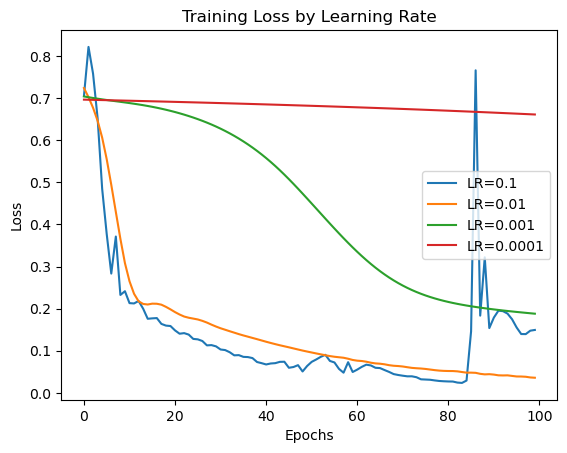

Learning Rate: 0.1, Accuracy: 0.9344262480735779
Learning Rate: 0.01, Accuracy: 0.9496487379074097
Learning Rate: 0.001, Accuracy: 0.9262295365333557
Learning Rate: 0.0001, Accuracy: 0.7341920137405396


In [106]:
# Plotting the loss over epochs for each learning rate
for lr, metrics in results.items():
    plt.plot(metrics['losses'], label=f'LR={lr}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss by Learning Rate')
plt.legend()
plt.show()

# Printing the accuracies
for lr, metrics in results.items():
    print(f'Learning Rate: {lr}, Accuracy: {metrics["accuracy"]}')


In [70]:
import torch
import torch.nn as nn
import torch.optim as optim


# Initialize the MLP
model = MLP()

# Loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses=[]
# Training the model
epochs = 100
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Store the loss
    losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

# Evaluating the model's performance can be done on the test set after training
# For simplicity, this example focuses on the training process


Epoch [10/100], Loss: 0.6749922633171082
Epoch [20/100], Loss: 0.645966649055481
Epoch [30/100], Loss: 0.5949695706367493
Epoch [40/100], Loss: 0.5150511264801025
Epoch [50/100], Loss: 0.41325098276138306
Epoch [60/100], Loss: 0.31353721022605896
Epoch [70/100], Loss: 0.24725818634033203
Epoch [80/100], Loss: 0.21563532948493958
Epoch [90/100], Loss: 0.200766459107399
Epoch [100/100], Loss: 0.1908561885356903


In [71]:
def calculate_accuracy(y_true, y_pred):
    predicted_classes = torch.round(y_pred)
    correct = (predicted_classes == y_true).float()
    accuracy = correct.sum() / len(correct)
    return accuracy.item()

In [72]:
accuracies = []  # List to store accuracy for each epoch
epochs = 100
for epoch in range(epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Calculate accuracy
    accuracy = calculate_accuracy(y_train_tensor, outputs)
    accuracies.append(accuracy)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}, Accuracy: {accuracy}')

Epoch [10/100], Loss: 0.18202872574329376, Accuracy: 0.9343878030776978
Epoch [20/100], Loss: 0.1741229146718979, Accuracy: 0.9367311000823975
Epoch [30/100], Loss: 0.16686731576919556, Accuracy: 0.9399531483650208
Epoch [40/100], Loss: 0.1597253680229187, Accuracy: 0.9440538883209229
Epoch [50/100], Loss: 0.152338907122612, Accuracy: 0.9466900825500488
Epoch [60/100], Loss: 0.14480029046535492, Accuracy: 0.9516695737838745
Epoch [70/100], Loss: 0.13710518181324005, Accuracy: 0.9560632705688477
Epoch [80/100], Loss: 0.12936614453792572, Accuracy: 0.95782071352005
Epoch [90/100], Loss: 0.12174168229103088, Accuracy: 0.9598711133003235
Epoch [100/100], Loss: 0.11438808590173721, Accuracy: 0.9636789560317993


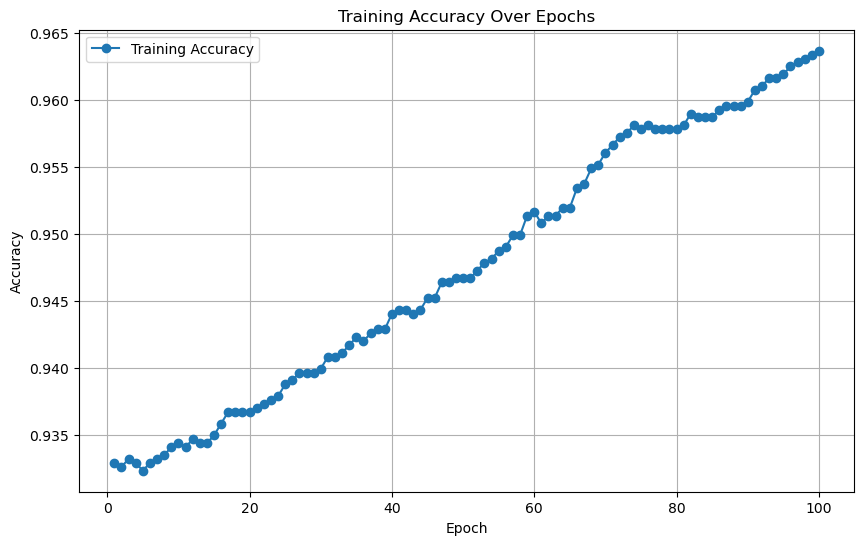

In [73]:
import matplotlib.pyplot as plt

# Assuming 'epochs' is the total number of epochs
epoch_range = range(1, epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epoch_range, accuracies, label='Training Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Model in evaluation mode
model.eval()

# Forward pass on the test set
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = (y_pred_tensor.numpy() > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy, precision, recall, f1


(0.9391100702576113,
 0.9169435215946844,
 0.9108910891089109,
 0.9139072847682118)

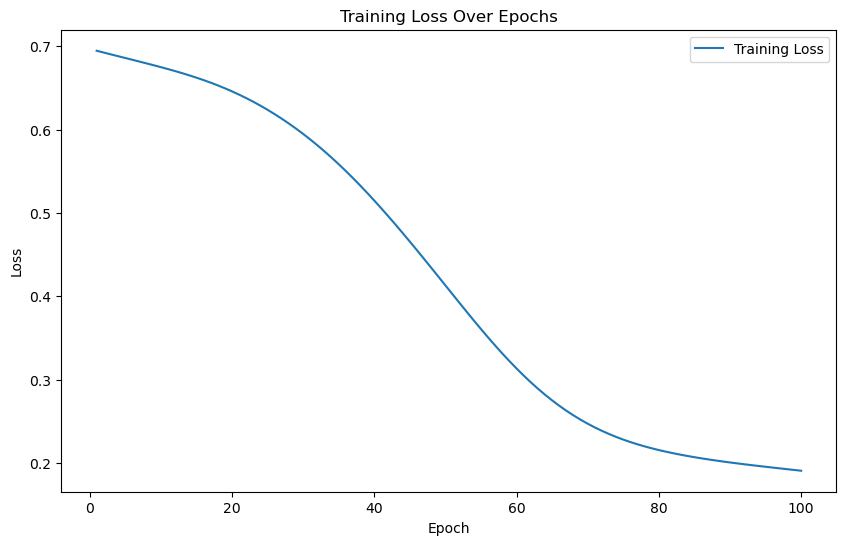

In [75]:
import matplotlib.pyplot as plt

# Assuming 'epochs' is a range object or list of epoch numbers
epochs = range(1, len(losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()
